![img](https://miro.medium.com/max/802/1*u7swL7CrX0UW_lIScu1eDQ.png)
# 1C. Introduction to Machine Learning with H2O-3-automl

In this tutorial, we will use the subset of the loan-level dataset from Fannie Mae and Freddie Mac. Firstly, we will solve a binary classification problem (predicting if a loan is delinquent or not). Then, we will explore a regression use-case (predicting interest rates on the same dataset). We will try to do both use-cases using Automatic Machine Learning (AutoML), and we will do so using H2O-3 in Python.

### Requierements

In [1]:
# installing java
! apt-get install default-jre
! java -version
# install h2o
! pip install h2o


Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.8MB 52kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=e6bf715d66c9047a09efdb1f3fd9f50852bbef84a03b187d6dcd3a7bbc225f59
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


### Task 1: Initial Setup

We will use H2O AutoML to make the same predictions as in the previous two tutorials:

*  Predict whether a mortgage loan will be delinquent or not
*  Predict the interest rate for each loan

In [2]:
# Libraries
import h2o
from h2o.automl import *
%matplotlib inline

In [3]:
# Initialize H2O instance
import os

startup  = '/home/h2o/bin/aquarium_startup'
shutdown = '/home/h2o/bin/aquarium_stop'

if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
else:
    local_url = 'http://localhost:54321'
    aquarium = False

In [4]:
h2o.init(url = local_url)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpivv_79e4
  JVM stdout: /tmp/tmpivv_79e4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpivv_79e4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_rxkxwq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
# Dataset from AWS S3 instance and we are using a subset with 50k rows.
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/H2O-3-Tutorials/loan_level_50k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Task 2: AutoML Concepts

AutoML ► Choosing the best machine learning models and tuning them can be time consuming and exhaustive. Often, it requires levels of expertise to know what parameters to tune. The field of AutoML focuses on solving this issue. AutoML is useful both for experts, by automating the process of choosing and tuning a model; and for non-experts as well, by helping them to create high performing models in a short time frame. Some of the aspects of machine learning that can be automated include data preparation, which can include imputation, one-hot encoding, feature selection/extraction, and also feature engineering. Another aspect that can be automated is the model generation, which includes training a model and tuning it with cartesian or random grid search. Lastly, a third aspect that could be using ensembles, as they usually outperform individual models.

The current version of AutoML trains and cross-validates the following model: GLMs, a Random Forest, an Extremely-Randomized Forest, a random grid of Gradient Boosting Machines (GBMs), XGBoosts, a random grid of Deep Neural Nets, and a Stacked Ensemble of all the models.

Stacked Ensembles ► Ensemble machine learning methods use multiple learning algorithms to obtain better predictive performance than the ones that could be obtained from any of the constituent learning algorithms. Many of the popular modern machine learning algorithms are actually ensembles. For example, Random Forest and Gradient Boosting Machine (GBM) are both ensemble learners. Both bagging (e.g., Random Forest) and boosting (e.g., GBM) are methods for ensembling that take a collection of weak learners (e.g., decision tree) and form a single, strong learner.


### Task 3: Start Experiment

In [6]:
# Dataset head
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE
730,199903,N,202902,16620,30,1,O,94,29,138000,94,7,T,N,FRM,WV,SF,25300,F199Q1000037,P,360,2,Other sellers,Other servicers,TRUE,FALSE
638,199905,N,202904,42020,nan,1,O,67,28,160000,67,7.375,T,N,FRM,CA,SF,93400,F199Q1000067,N,360,2,CROSSLAND MORTGAGE C,CHASEMTGECO,TRUE,FALSE
577,199903,N,202902,12580,12,1,O,80,53,43000,80,7.25,T,N,FRM,MD,SF,21200,F199Q1000086,N,360,1,ACCUBANC MORTGAGE CO,GMACMTGECORP,FALSE,TRUE
693,199905,N,202904,nan,nan,1,O,80,43,93000,80,7.125,R,N,FRM,SD,SF,57500,F199Q1000104,P,360,1,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
739,199905,,202904,16700,nan,1,S,80,25,200000,80,6.875,R,N,FRM,SC,CO,29400,F199Q1000107,P,360,2,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
695,199905,,202904,42044,0,1,O,40,6,135000,40,6.875,R,N,FRM,CA,SF,92800,F199Q1000121,C,360,2,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
753,199905,N,202904,41740,0,1,O,80,17,59000,80,7,R,N,FRM,CA,CO,92000,F199Q1000122,P,360,1,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
712,199905,,202904,nan,nan,1,O,80,28,126000,80,7.125,R,N,FRM,MI,SF,48800,F199Q1000123,N,360,2,Other sellers,Other servicers,TRUE,FALSE


In [7]:
# Descriptive statistics
loan_level.describe()

Rows:49930
Cols:27




,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
type,int,int,enum,int,int,int,int,enum,int,int,int,int,real,enum,enum,enum,enum,enum,int,string,enum,int,int,enum,enum,enum,enum
mins,300.0,199902.0,,202404.0,10180.0,0.0,1.0,,6.0,1.0,10000.0,6.0,5.0,,,,,,600.0,NaN,,301.0,1.0,,,,
mean,712.3066000684777,200025.6742239134,,203023.3970759064,30705.258665299156,7.719609503855924,1.0281994792709799,,76.08864765261984,32.83933763635985,136369.6775485679,75.7452382382984,7.185977708792308,,,,,,55401.434122501334,NaN,,359.85083116362875,1.6294507784479122,,,,
maxs,830.0,200403.0,,203312.0,49740.0,50.0,4.0,,160.0,65.0,529000.0,100.0,10.625,,,,,,99900.0,NaN,,361.0,2.0,,,,
sigma,54.97355321804355,109.77460105158103,,110.47953133322676,11363.12482267641,12.042273590466618,0.21962330364819396,,15.062080123474091,11.16538336497283,60632.74328123587,14.867228331350553,0.5835949914330252,,,,,,29512.32285922538,NaN,,1.9974697613404884,0.48295669536262226,,,,
zeros,0,0,,0,0,31023,0,,0,0,0,0,0,,,,,,0,0,,0,0,,,,
missing,279,0,13067,0,7029,5064,0,0,2,1437,0,1,0,0,504,0,0,13,4,0,0,0,23,0,0,0,0
0,707.0,200211.0,N,202903.0,33340.0,0.0,1.0,O,60.0,57.0,136000.0,60.0,6.25,R,N,FRM,WI,SF,53000.0,F199Q1000018,C,317.0,2.0,Other sellers,Other servicers,TRUE,FALSE
1,691.0,200302.0,N,202901.0,15940.0,0.0,1.0,O,65.0,25.0,130000.0,65.0,5.875,R,N,FRM,OH,SF,44700.0,F199Q1000023,P,312.0,2.0,Other sellers,Other servicers,TRUE,FALSE
2,730.0,199903.0,N,202902.0,16620.0,30.0,1.0,O,94.0,29.0,138000.0,94.0,7.0,T,N,FRM,WV,SF,25300.0,F199Q1000037,P,360.0,2.0,Other sellers,Other servicers,TRUE,FALSE


In [8]:
# Looking at the DELINQUENT col wich is the response for our classification problem.
loan_level["DELINQUENT"].table()

DELINQUENT,Count
FALSE,48118
TRUE,1812


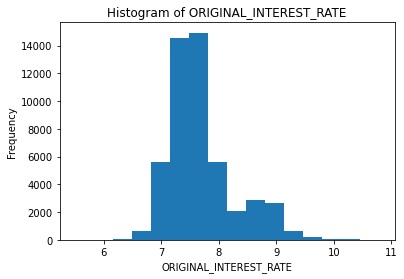

In [9]:
# let's take a quick look at the response for our regression use-case.
loan_level["ORIGINAL_INTEREST_RATE"].hist()

the average interest rate ranges from 7% to 8%

In [10]:
# Splitting data in two sets train and test
train, test = loan_level.split_frame([0.8], seed=42)

In [11]:
# Let's check the number of rows
print("train:%d test:%d" % (train.nrows, test.nrows))

train:39984 test:9946


### Task 4: H2O AutoML Classification

In [12]:
# Definnig target and useless cols
y = "DELINQUENT"
ignore = ["DELINQUENT", 
          "PREPAID", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "PRODUCT_TYPE"] 
x = list(set(train.names) - set(ignore))

In [13]:
# Ready to run AutoML
H2OAutoML(nfolds=5, max_runtime_secs=3600, max_models=None, stopping_metric='AUTO', stopping_tolerance=None, stopping_rounds=3, seed=None, project_name=None)

In [14]:
# Setting the limits to 25 models that will take 15 minutes
aml = H2OAutoML(max_runtime_secs = 900, 
                max_models = 25,  
                seed = 42, 
                project_name='classification',
                sort_metric = "AUC")

%time aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 56.9 s, sys: 2.14 s, total: 59.1 s
Wall time: 14min 2s


The only required parameters for H2O's AutoML are, y training_frame, and max_runtime_secs, which let us train AutoML for ‘x' amount of seconds and/or max_models, which would train a maximum number of models. Please note that max_runtime_secs has a default value, while max_models does not. The seed is the usual parameter that we set for reproducibility purposes. We also need a project name because we will do both classification and regression with AutoML. Lastly, we are using the default number of folds for cross-validation.

In [15]:
# Checking the leaderboard
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210505_024310,0.859952,0.118266,0.232781,0.314899,0.173837,0.0302192
StackedEnsemble_BestOfFamily_AutoML_20210505_024310,0.858978,0.118501,0.23096,0.320765,0.173965,0.0302639
GLM_1_AutoML_20210505_024310,0.853877,0.120899,0.205956,0.336445,0.175755,0.0308898
XGBoost_3_AutoML_20210505_024310,0.849281,0.121242,0.216121,0.35151,0.175255,0.0307143
GBM_grid__1_AutoML_20210505_024310_model_3,0.843161,0.122835,0.208295,0.362702,0.175839,0.0309194
GBM_grid__1_AutoML_20210505_024310_model_2,0.840551,0.124513,0.202748,0.327625,0.176784,0.0312525
GBM_1_AutoML_20210505_024310,0.840535,0.126248,0.188024,0.320055,0.178511,0.0318662
XGBoost_2_AutoML_20210505_024310,0.839416,0.1247,0.197794,0.330836,0.177566,0.0315297
XGBoost_grid__1_AutoML_20210505_024310_model_6,0.835447,0.125231,0.202592,0.362008,0.17693,0.0313041
GBM_2_AutoML_20210505_024310,0.835396,0.127104,0.186971,0.361486,0.17828,0.0317838


In [16]:
# two more columns for the leaderboars "training time, and prediction time per row"
lb2 = get_leaderboard(aml, extra_columns = 'ALL')
lb2.head(rows = lb2.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210505_024310,0.859952,0.118266,0.232781,0.314899,0.173837,0.0302192,11039,0.227257,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210505_024310,0.858978,0.118501,0.23096,0.320765,0.173965,0.0302639,6387,0.051126,StackedEnsemble
GLM_1_AutoML_20210505_024310,0.853877,0.120899,0.205956,0.336445,0.175755,0.0308898,12237,0.001951,GLM
XGBoost_3_AutoML_20210505_024310,0.849281,0.121242,0.216121,0.35151,0.175255,0.0307143,2833,0.003123,XGBoost
GBM_grid__1_AutoML_20210505_024310_model_3,0.843161,0.122835,0.208295,0.362702,0.175839,0.0309194,4602,0.022199,GBM
GBM_grid__1_AutoML_20210505_024310_model_2,0.840551,0.124513,0.202748,0.327625,0.176784,0.0312525,5940,0.02834,GBM
GBM_1_AutoML_20210505_024310,0.840535,0.126248,0.188024,0.320055,0.178511,0.0318662,2573,0.018777,GBM
XGBoost_2_AutoML_20210505_024310,0.839416,0.1247,0.197794,0.330836,0.177566,0.0315297,3806,0.007097,XGBoost
XGBoost_grid__1_AutoML_20210505_024310_model_6,0.835447,0.125231,0.202592,0.362008,0.17693,0.0313041,4401,0.009896,XGBoost
GBM_2_AutoML_20210505_024310,0.835396,0.127104,0.186971,0.361486,0.17828,0.0317838,2790,0.021906,GBM


In [17]:
# Checking the best model performance
aml.leader.model_performance(test_data=test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.034225247167364276
RMSE: 0.18500066801869736
LogLoss: 0.13592307893685643
Null degrees of freedom: 9945
Residual degrees of freedom: 9927
Null deviance: 3327.7962854656025
Residual deviance: 2703.7818862119484
AIC: 2741.7818862119484
AUC: 0.8277612921438406
AUCPR: 0.2206564110895138
Gini: 0.6555225842876813

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19781012755456528: 


,,FALSE,TRUE,Error,Rate
0,FALSE,9286.0,265.0,0.0277,(265.0/9551.0)
1,TRUE,279.0,116.0,0.7063,(279.0/395.0)
2,Total,9565.0,381.0,0.0547,(544.0/9946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.197810,0.298969,143.0
1,max f2,0.057982,0.382820,264.0
2,max f0point5,0.271705,0.322976,101.0
3,max accuracy,0.493444,0.960688,31.0
4,max precision,0.782841,0.666667,2.0
5,max recall,0.001650,1.000000,395.0
6,max specificity,0.815242,0.999895,0.0
7,max absolute_mcc,0.206106,0.270733,138.0
8,max min_per_class_accuracy,0.034024,0.760235,304.0
9,max mean_per_class_accuracy,0.034024,0.761130,304.0



Gains/Lift Table: Avg response rate:  3.97 %, avg score:  3.70 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010054,0.375601,10.575494,10.575494,0.420000,0.495784,0.420000,0.495784,0.106329,0.106329,957.549367,957.549367,0.100256
1,2,0.020008,0.275395,8.393249,9.489854,0.333333,0.322138,0.376884,0.409397,0.083544,0.189873,739.324895,848.985433,0.176890
2,3,0.030062,0.223112,5.791342,8.252894,0.230000,0.245588,0.327759,0.354612,0.058228,0.248101,479.134177,725.289361,0.227056
3,4,0.040016,0.187385,4.832477,7.402086,0.191919,0.207209,0.293970,0.317946,0.048101,0.296203,383.247667,640.208638,0.266782
4,5,0.050070,0.160266,2.769772,6.471903,0.110000,0.171283,0.257028,0.288496,0.027848,0.324051,176.977215,547.190280,0.285311
5,6,0.100040,0.091158,2.735828,4.605743,0.108652,0.120335,0.182915,0.204500,0.136709,0.460759,173.582762,360.574264,0.375638
6,7,0.150010,0.062868,2.583837,3.932226,0.102616,0.075450,0.156166,0.161512,0.129114,0.589873,158.383720,293.222588,0.458055
7,8,0.200080,0.046619,1.921346,3.429001,0.076305,0.053937,0.136181,0.134591,0.096203,0.686076,92.134614,242.900070,0.506095
8,9,0.300020,0.027829,0.987938,2.615858,0.039235,0.036063,0.103887,0.101771,0.098734,0.784810,-1.206225,161.585842,0.504839
9,10,0.400060,0.018043,0.607351,2.113605,0.024121,0.022489,0.083941,0.081945,0.060759,0.845570,-39.264932,111.360529,0.463934


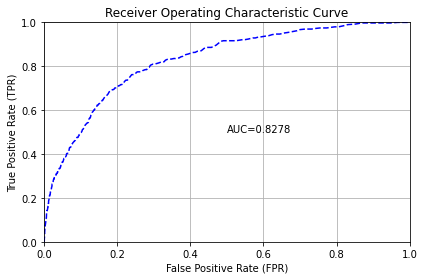

In [18]:
# ROC curve
%matplotlib inline
aml.leader.model_performance(test_data=test).plot()

In [19]:
# Making some predictions
aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,FALSE,TRUE
FALSE,0.966834,0.0331656
FALSE,0.987151,0.0128494
FALSE,0.994973,0.0050271
FALSE,0.934458,0.065542
FALSE,0.98394,0.01606
FALSE,0.99417,0.00583011
FALSE,0.996065,0.00393505
FALSE,0.998342,0.00165819
FALSE,0.995566,0.00443386
FALSE,0.993093,0.00690672


As we mentioned in the first tutorial, the predictions we get are based on a probability. In the frame above, we have a probability for FALSE, and another one for TRUE. The prediction, predict, is based on the threshold that maximizes the F1 score. For example, the threshold that maximizes the F1 is about 0.1061, meaning that if the probability of TRUE is greater than the threshold, the predicted label would be TRUE.

### Task 5: H2O AutoML Regression

For our regression use-case, we are using the same dataset and the same training and test sets. But we do need to choose our predictors and response columns, and we will do it as follow:

In [20]:
y_reg = "ORIGINAL_INTEREST_RATE"

ignore_reg = ["ORIGINAL_INTEREST_RATE", 
              "FIRST_PAYMENT_DATE", 
              "MATURITY_DATE", 
              "MORTGAGE_INSURANCE_PERCENTAGE", 
              "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
              "LOAN_SEQUENCE_NUMBER", 
              "PREPAID", 
              "DELINQUENT", 
              "PRODUCT_TYPE"]

x_reg = list(set(train.names) - set(ignore_reg))

In [21]:
# Let's see the variables
print("y:", y_reg, "\nx:", x_reg)

y: ORIGINAL_INTEREST_RATE 
x: ['CREDIT_SCORE', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'CHANNEL', 'ORIGINAL_UPB', 'PROPERTY_TYPE', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'LOAN_PURPOSE', 'METROPOLITAN_STATISTICAL_AREA', 'POSTAL_CODE', 'ORIGINAL_LOAN_TERM', 'OCCUPANCY_STATUS', 'ORIGINAL_LOAN_TO_VALUE', 'SELLER_NAME', 'NUMBER_OF_BORROWERS', 'SERVICER_NAME', 'FIRST_TIME_HOMEBUYER_FLAG', 'PROPERTY_STATE', 'NUMBER_OF_UNITS']


In [22]:
# Setting max_run_time to 900 seconds or something like 15 minutes
aml = H2OAutoML(max_runtime_secs = 900,
                seed = 42,
                project_name = 'regression',
                stopping_metric = "RMSE",
                sort_metric = "RMSE")

%time aml.train(x = x_reg, y = y_reg, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 50.9 s, sys: 1.86 s, total: 52.7 s
Wall time: 13min 51s


In [23]:
# Leaderboard
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
GBM_2_AutoML_20210505_025747,0.431104,0.185851,0.185851,0.313055,0.0509991
GBM_3_AutoML_20210505_025747,0.431259,0.185984,0.185984,0.313147,0.0510037
GBM_4_AutoML_20210505_025747,0.432376,0.186949,0.186949,0.313967,0.051136
GBM_1_AutoML_20210505_025747,0.432502,0.187058,0.187058,0.314691,0.0511546
GBM_5_AutoML_20210505_025747,0.434864,0.189107,0.189107,0.316412,0.0514232
XGBoost_grid__1_AutoML_20210505_025747_model_2,0.435758,0.189885,0.189885,0.317878,0.0515452
GBM_grid__1_AutoML_20210505_025747_model_2,0.436157,0.190233,0.190233,0.319127,0.0515591
XGBoost_3_AutoML_20210505_025747,0.437999,0.191843,0.191843,0.319627,0.0518013
XGBoost_grid__1_AutoML_20210505_025747_model_3,0.438339,0.192141,0.192141,0.319768,0.0518535
StackedEnsemble_AllModels_AutoML_20210505_025747,0.438569,0.192343,0.192343,0.321571,0.0517757


In [24]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

# Get the top GBM model
gbm = h2o.get_model([mid for mid in model_ids if "GBM" in mid][0])

To retrieve different models, you just need to change the name of the model, GBM, to the model that you want. For example, if you wanted to get the best XGBoost in the leaderboard, you would need to make the following change (you do not need to run the following line of code, this is just an example)

In [25]:
xgb = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [26]:
# Let's look at the parameters
print("ntrees = ", gbm.params['ntrees'])
print("max depth = ", gbm.params['max_depth'])
print("learn rate = ", gbm.params['learn_rate'])
print("sample rate = ", gbm.params['sample_rate'])

ntrees =  {'default': 50, 'actual': 61, 'input': 10000}
max depth =  {'default': 5, 'actual': 7, 'input': 7}
learn rate =  {'default': 0.1, 'actual': 0.1, 'input': 0.1}
sample rate =  {'default': 1.0, 'actual': 0.8, 'input': 0.8}


In [27]:
gbm.params

{'auc_type': {'actual': 'AUTO', 'default': 'AUTO', 'input': 'AUTO'},
 'balance_classes': {'actual': False, 'default': False, 'input': False},
 'build_tree_one_node': {'actual': False, 'default': False, 'input': False},
 'calibrate_model': {'actual': False, 'default': False, 'input': False},
 'calibration_frame': {'actual': None, 'default': None, 'input': None},
 'categorical_encoding': {'actual': 'Enum',
  'default': 'AUTO',
  'input': 'AUTO'},
 'check_constant_response': {'actual': True, 'default': True, 'input': True},
 'checkpoint': {'actual': None, 'default': None, 'input': None},
 'class_sampling_factors': {'actual': None, 'default': None, 'input': None},
 'col_sample_rate': {'actual': 0.8, 'default': 1.0, 'input': 0.8},
 'col_sample_rate_change_per_level': {'actual': 1.0,
  'default': 1.0,
  'input': 1.0},
 'col_sample_rate_per_tree': {'actual': 0.8, 'default': 1.0, 'input': 0.8},
 'custom_distribution_func': {'actual': None, 'default': None, 'input': None},
 'custom_metric_func'

In [28]:
# model summary
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20210505_025747


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,61.0,61.0,90183.0,7.0,7.0,7.0,40.0,114.0,90.34426




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.15269688726200395
RMSE: 0.3907644907895342
MAE: 0.2833111805050504
RMSLE: 0.04631940499237696
Mean Residual Deviance: 0.15269688726200395

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.185850763132656
RMSE: 0.43110412098779105
MAE: 0.3130554316606902
RMSLE: 0.05099909719685156
Mean Residual Deviance: 0.185850763132656

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.31305543,0.0012365212,0.3131201,0.3150083,0.3116841,0.31240928,0.31305534
1,mean_residual_deviance,0.18585072,0.0027274468,0.18724704,0.18997894,0.1834289,0.18450591,0.18409282
2,mse,0.18585072,0.0027274468,0.18724704,0.18997894,0.1834289,0.18450591,0.18409282
3,r2,0.4552014,0.006295811,0.45276675,0.44714057,0.45646077,0.4644781,0.4551608
4,residual_deviance,0.18585072,0.0027274468,0.18724704,0.18997894,0.1834289,0.18450591,0.18409282
5,rmse,0.43109483,0.0031561707,0.4327205,0.43586573,0.428286,0.4295415,0.4290604
6,rmsle,0.0509982,3.378077E-4,0.05107473,0.051535763,0.050640408,0.050850473,0.050889626



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-05-05 03:00:07,16.646 sec,0.0,0.584073,0.441749,0.341141
1,,2021-05-05 03:00:07,16.907 sec,5.0,0.502196,0.378127,0.252201
2,,2021-05-05 03:00:08,17.171 sec,10.0,0.462878,0.344986,0.214256
3,,2021-05-05 03:00:08,17.444 sec,15.0,0.442329,0.327254,0.195655
4,,2021-05-05 03:00:08,17.854 sec,20.0,0.428096,0.314578,0.183266
5,,2021-05-05 03:00:09,18.261 sec,25.0,0.419515,0.307061,0.175992
6,,2021-05-05 03:00:09,18.550 sec,30.0,0.412482,0.300850,0.170142
7,,2021-05-05 03:00:09,18.809 sec,35.0,0.407119,0.296378,0.165746
8,,2021-05-05 03:00:10,19.074 sec,40.0,0.402170,0.292261,0.161741
9,,2021-05-05 03:00:10,19.359 sec,45.0,0.398234,0.289090,0.158590



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME,16180.680664,1.000000,0.463428
1,SERVICER_NAME,5225.981445,0.322977,0.149676
2,PROPERTY_STATE,3795.213379,0.234552,0.108698
3,ORIGINAL_UPB,1759.453247,0.108738,0.050392
4,OCCUPANCY_STATUS,1692.369629,0.104592,0.048471
5,LOAN_PURPOSE,1575.811401,0.097388,0.045133
6,CREDIT_SCORE,1303.763184,0.080575,0.037341
7,ORIGINAL_LOAN_TO_VALUE,997.313965,0.061636,0.028564
8,ORIGINAL_COMBINED_LOAN_TO_VALUE,559.708801,0.034591,0.016031
9,ORIGINAL_DEBT_TO_INCOME_RATIO,492.697510,0.030450,0.014111


In [29]:
# Leader performance
gbm.model_performance(test_data=test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.18479878271260888
RMSE: 0.4298822893683908
MAE: 0.3130563833418824
RMSLE: 0.05088511834510968
Mean Residual Deviance: 0.18479878271260888


In [30]:
# Best model performance in case is different to gbm
aml.leader.model_performance(test_data=test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.18479878271260888
RMSE: 0.4298822893683908
MAE: 0.3130563833418824
RMSLE: 0.05088511834510968
Mean Residual Deviance: 0.18479878271260888


In [31]:
# Making some predicitons
pred = gbm.predict(test)
pred = pred.cbind(test['ORIGINAL_INTEREST_RATE'])
pred.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
6.92051,7.5
7.08853,6.625
7.18485,7
7.20468,7.15
7.17336,7
7.32891,7.125
6.99801,8.75
6.93223,6.5
7.05544,7
7.19802,7.25


Out of the first ten predictions, most of them are very close to the actual values, with the exception of some predictions, such as the seventh prediction, which is 6.89, compared to the actual value which is 8.75. Because the RMSE is higher than the MAE, we can deduce that we have a couple of instances similar to the one mentioned above, because the larger errors are penalized more.

### Task 6: H2O AutoML Classification in Flow

For colab notebook Flow is not available

In [32]:
# Import a file into flow
# importFiles ["https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_50k.csv"]

### Task 7: H2O AutoML Regression in Flow

Scroll up to the Assistance panel once again, and click on runAutoML. We will do something similar to what we just did in the previous task. In the AutoML settings, change Project Name to flow-automl-regression, for Training Frame choose train, for Response Column choose ORIGINAL_INTEREST_RATE, and choose test for the Leaderboard Frame.

## Finally my badge
https://bcert.me/bc/html/show-badge.html?b=upwnohpb
![img](https://bcert.me/bc/html/img/badges/generated/badge-9209.png)
